In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [3]:
def load_group_data(file, name_blood, name_slh):
    df_blood = pd.read_excel(file, sheet_name=name_blood)
    df_slh = pd.read_excel(file, sheet_name=name_slh)
    df_blood['cow_id'] = df_blood['Land'] + ' ' + df_blood['Levensnr'].astype(str)
    return df_blood, df_slh

In [4]:
def get_same_cows_ids(df_blood, df_slh):
    cow_ids_blood = set(df_blood['cow_id'])
    cow_ids_slh = set(df_slh['ID nummer'])
    return  cow_ids_blood.intersection(cow_ids_slh)

In [5]:
def combine_matching_cows(df_blood, df_slh, same_cows_ids):
    df_blood_filtered = df_blood[df_blood['cow_id'].isin(same_cows_ids)]
    df_slh_filtered = df_slh[df_slh['ID nummer'].isin(same_cows_ids)]
    
    df_combined = pd.merge(df_blood_filtered, df_slh_filtered, left_on='cow_id', right_on='ID nummer', how='inner')
    
    return df_combined

In [6]:
def load_stallijst_data(file, name_stallijst):
    df_stallijst = pd.read_excel(file, sheet_name=name_stallijst)
    
    return df_stallijst

In [7]:
def combine_stallijst(df_combined, df_stallijst):
    df_final_combined = pd.merge(df_combined, df_stallijst, left_on='Levensnr', right_on='Calf ID', how='inner')
    
    return df_final_combined

In [8]:
def load_arrival_weights(file, name_arrival_weights):
    df_arrival_weights = pd.read_excel(file, sheet_name=name_arrival_weights)
    
    return df_arrival_weights

In [9]:
def add_arrival_weight(df_existing, df_arrival_weights):
    df_merged = pd.merge(df_existing, df_arrival_weights[['Stable', 'Handelaar', 'Arrival date', 'Arrival weight']],
                         left_on=['Merchant', 'Arrival Date at Veal Farm'],
                         right_on=['Handelaar', 'Arrival date'],
                         how='left')
    
    return df_merged

In [10]:
def load_individual_treatments(file, name_individual_treatments):
    df_individual_treatments = pd.read_excel(file, sheet_name=name_individual_treatments)
    
    return df_individual_treatments

In [11]:
def add_sick_status(df_existing, df_individual_treatments):
    df_individual_treatments['Datum'] = pd.to_datetime(df_individual_treatments['Datum'], errors='coerce')
    
    df_earliest_sickness = df_individual_treatments.groupby('Lev.nr')['Datum'].min().reset_index()
    
    df_merged = pd.merge(df_existing, df_earliest_sickness, left_on='Calf ID + Country', right_on='Lev.nr', how='left')
    
    df_merged['Sick'] = df_merged['Datum'].apply(lambda x: 1 if pd.notna(x) else 0)
    
    df_merged.rename(columns={'Datum': 'Sickness Date'}, inplace=True)
    
    return df_merged

# Antens farm

## Group 2348201

In [34]:
df_blood, df_slh = load_group_data(
    'Structured data.xlsx', name_blood=0, name_slh=1
)

In [35]:
same_cows_2348201 = get_same_cows_ids(df_blood, df_slh)

In [36]:
len(same_cows_2348201)

549

**There are 549 same cows in both datasets**

## Group 2242208

In [42]:
df_blood_2242208, df_slh_2242208 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2242208 - blood samples',
    name_slh='Group 2242208 Slaughterhouse'
)

In [45]:
same_cows_2242208 = get_same_cows_ids(df_blood_2242208, df_slh_2242208)

In [46]:
len(same_cows_2242208)

491

**There are 491 same cows in both datasets**

## Group 2211207 

In [48]:
df_blood_2211207, df_slh_2211207 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2211207 - blood samples',
    name_slh='Group 2211207 Slaughterhouse',
)

In [49]:
same_cows_2211207 = get_same_cows_ids(df_blood_2211207, df_slh_2211207)

In [50]:
len(same_cows_2211207)

91

**There are 91 same cows in both datasets**

## Group 2133206

In [51]:
df_blood_2133206, df_slh_2133206 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2133206 - blood samples',
    name_slh='Group 2133206 Slaughterhouse',
)

In [52]:
same_cows_2133206 = get_same_cows_ids(df_blood_2133206, df_slh_2133206) 

In [53]:
len(same_cows_2133206)

511

**There are 511 same cows in both datasets**

# Stagri farm

## Group 2338338

In [55]:
df_blood_2338338, df_slh_2338338 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2338338 - blood samples',
    name_slh='Group 2338338 Slaughterhouse',
)

In [57]:
same_cows_2338338 = get_same_cows_ids(df_blood_2338338, df_slh_2338338) 

In [58]:
len(same_cows_2338338)

898

## Group 2309337

In [60]:
df_blood_2309337, df_slh_2309337 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2309337 - blood samples',
    name_slh='Group 2309337 Slaughterhouse',
)

In [61]:
same_cows_2309337 = get_same_cows_ids(df_blood_2309337, df_slh_2309337) 

In [63]:
len(same_cows_2309337)

152

## Group 2232336

In [64]:
df_blood_2232336, df_slh_2232336 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2232336 - blood samples',
    name_slh='Group 2232336 Slaughterhouse',
)

In [65]:
same_cows_2232336 = get_same_cows_ids(df_blood_2232336, df_slh_2232336) 

In [66]:
len(same_cows_2232336)

278

# Group 2128334

In [ ]:
df_blood_2128334, df_slh_2128334 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2128334 - blood samples',
    name_slh='Group 2128334 Slaughterhouse',
)

In [68]:
same_cows_2128334 = get_same_cows_ids(df_blood_2128334, df_slh_2128334) 

In [69]:
len(same_cows_2128334)

354

## Individual treatments data

In [72]:
treatments = pd.read_excel('Stagri structured data.xlsx', sheet_name='Individual treatments')

In [77]:
treatments.shape

(1484, 15)

In [79]:
treatments['Levensnummer'].unique().shape

(1484,)

In [75]:
cows_in_all_dfs = (same_cows_2338338 | same_cows_2309337 | same_cows_2232336 | same_cows_2128334).intersection(set(treatments['Levensnummer']))

In [76]:
len(cows_in_all_dfs)

898

# Borne farm

## Group 2412242

### Group 2412242 Pali

In [12]:
df_blood_2412242, df_slh_2412242 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2412242 - blood samples',
    name_slh='Group 2412242 SlaughterhouseP',
)

In [13]:
same_cows_2412242 = get_same_cows_ids(df_blood_2412242, df_slh_2412242) 

In [14]:
len(same_cows_2412242)

913

In [15]:
df_combined_2412242 = combine_matching_cows(df_blood_2412242, df_slh_2412242, same_cows_2412242)
print(df_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


In [16]:
df_stallijst_2412242 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2412242 Stallijst'
)

df_final_combined_2412242 = combine_stallijst(df_combined_2412242, df_stallijst_2412242)

print(df_final_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


In [17]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2412242, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


In [18]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [19]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [20]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [21]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [22]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [23]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               10             1.095290
HB3                              880            96.385542
S2                                10             1.095290
S3                               880            96.385542
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      718            78.641840
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

In [24]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3   S2   S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  5.2  5.6  0.0  0.0  0.0   O-            20      5    131.9      20-2-2024   
1  5.2  0.0  0.0  0.0  0.0   O+            20     10    131.5      20-2-2024   
2  6.5  7.5  0.0  0.0  0.0   O-            20      3    132.4      24-2-2024   
3  5.6  6.0  0.0  0.0  0.0   O+            30      8    139.8      21-2-2024   
4  5.2  6.4  0.0  0.0  0.0   R-            10      6    114.9      20-2-2024   

   ...  Merchant  Sex  Color Letter         Fur Color  \
0  ...  Boerkamp    1             Z         Zwartbont   
1  ...  Boerkamp    0             U  Eenkleurig bruin   
2  ...  Boerkamp    1             Z         Zwartbont   
3  ...  Boerkamp    0             U  Eenkleurig bruin   
4  ...  Boerkamp    1             U  Eenkleurig bruin   

  Arrival Date at Veal Farm Days at diary farm    Stable Arrival weight  \
0                2024-03-26                 35  Vd Borne           57.0   
1                2024-03-2

In [25]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [26]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2412242_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2412242_pali.columns)

pd.set_option('display.max_columns', None)

print(df_final_cleaned_2412242_pali.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')
    Country ID + Calf ID Country ID       Calf ID Birth Date  Sex    Stable  \
126      IE 214936132019         IE  214936132019  27-2-2024    1  Vd Borne   
901      IE 227118320960         IE  227118320960  14-2-2024    0  Vd Borne   
632      IE 213326515532         IE  213326515532  15-2-2024    1  Vd Borne   
44         DE 1267807728         DE    1267807728  24-2-2024    1  Vd Borne   
337      IE 226458410372         IE  226458410372  29-2-2024    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
126          

In [27]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          1     1         0    0
2          0     0         0    1
3          1     1         0    0
4          1     2         0    1


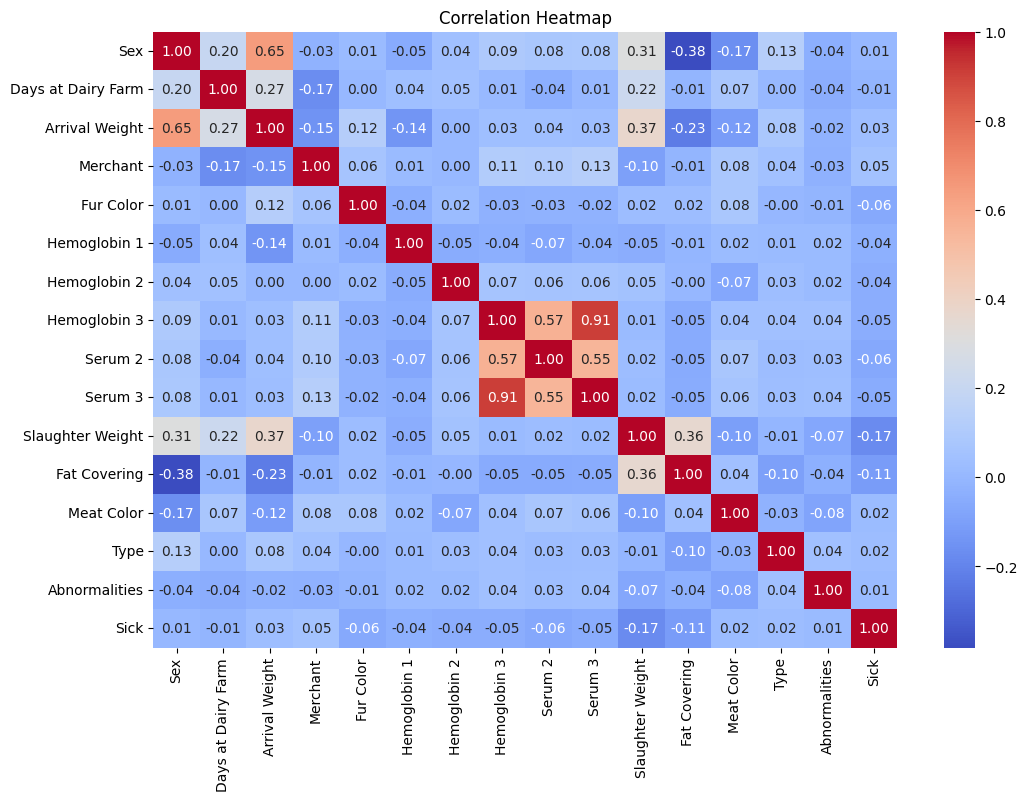

In [28]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Group 2336241

### Group 2336241 Pali

In [29]:
df_blood_2336241, df_slh_2336241 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2336241 - blood samples',
    name_slh='Group 2336241 SlaughterhouseP',
)

In [30]:
same_cows_2336241 = get_same_cows_ids(df_blood_2336241, df_slh_2336241) 

In [31]:
len(same_cows_2336241)

440

In [32]:
df_combined_2336241 = combine_matching_cows(df_blood_2336241, df_slh_2336241, same_cows_2336241)
print(df_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


In [33]:
df_stallijst_2336241 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2336241 Stallijst'
)

df_final_combined_2336241 = combine_stallijst(df_combined_2336241, df_stallijst_2336241)

print(df_final_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


In [34]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2336241, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


In [35]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [36]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [37]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves (1s in Sick column): {count_sick}')

Count of sick calves (1s in Sick column): 33


In [38]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [39]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [40]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'X', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [41]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.227273
HB3                              421            95.681818
S2                                 1             0.227273
S3                               421            95.681818
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      302            68.636364
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

In [42]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3   S2    S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  4.0  5.2  5.4  0.0  21.0   O0            30      6    172.3       4-8-2023   
1  4.2  6.5  0.0  0.0   0.0   O0            30      6    143.5       8-8-2023   
2  6.5  6.3  0.0  0.0   0.0   O-            20      6    140.5       6-8-2023   
3  4.8  6.5  0.0  0.0   0.0   O-            20      5    135.7       7-8-2023   
4  4.2  6.6  0.0  0.0   0.0   O+            20      5    137.9       7-8-2023   

  Slacht datum  Afwijkingen     Calf ID County ID  Merchant  Sex Color Letter  \
0     6-3-2024            1  1272852854        DE  Boerkamp    1            Z   
1     6-3-2024            0  1272867460        DE  Boerkamp    0            Z   
2     8-3-2024            1  1273641162        DE  Boerkamp    1            Z   
3     5-3-2024            1  1406949406        DE  lochimex    1            U   
4     5-3-2024            0  1505435824        DE  Boerkamp    1            U   

          Fur Color Arriva

In [43]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [44]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date',
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2336241_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2336241_pali.columns)

print(df_final_cleaned_2336241_pali.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')
    Country ID + Calf ID Country ID     Calf ID Birth Date  Sex    Stable  \
325        DE 1260223486         DE  1260223486   6-8-2023    1  Vd Borne   
109        FR 5945171375         FR  5945171375   3-8-2023    1  Vd Borne   
290        DE 1406928917         DE  1406928917   4-8-2023    1  Vd Borne   
198        DE 1406810580         DE  1406810580   3-8-2023    1  Vd Borne   
91         FR 3803659418         FR  3803659418  14-8-2023    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
325                  30  

In [45]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    0
2          0     1         0    1
3          1     1         1    1
4          1     2         0    1


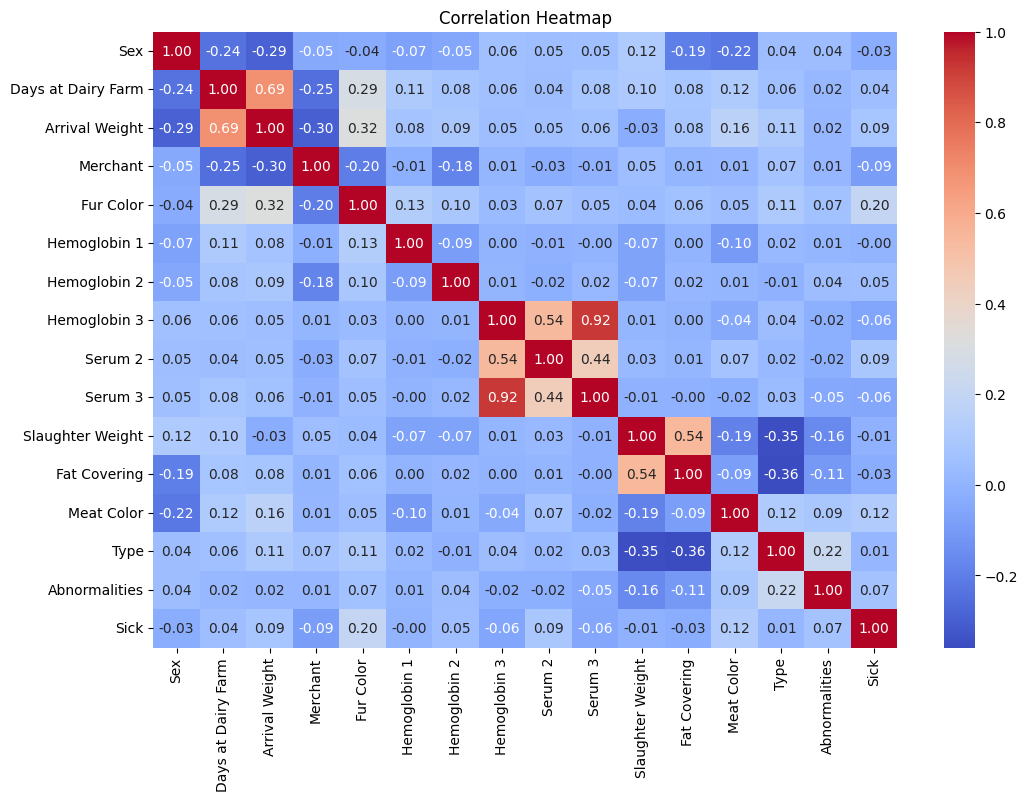

In [46]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Group 2308249

### Group 2308249 S

In [273]:
df_blood_2308249, df_slh_2308249 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2308249 - blood samples',
    name_slh='Group 2308249 Slaughterhouse',
)

In [274]:
same_cows_2308249 = get_same_cows_ids(df_blood_2308249, df_slh_2308249) 

In [275]:
len(same_cows_2308249)

546

In [276]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249, same_cows_2308249)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


In [277]:
df_stallijst_2308249 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm'],
      dtype='object')


In [278]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


In [279]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [280]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [281]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves (1s in Sick column): {count_sick}')

Count of sick calves (1s in Sick column): 158


In [282]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [283]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'WerkNr', 'Gewicht',
       'Soort', 'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse',
       'Slacht Datum', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [284]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [285]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                4             0.732601
HB3                              520            95.238095
HB4                              520            95.238095
S2                                 4             0.732601
S3                               520            95.238095
S4                               520            95.238095
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant      

In [286]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3  HB4   S2   S3   S4  Gewicht  Soort  Kleur  Vet  \
0  6.4  6.2  0.0  0.0  0.0  0.0  0.0    112.0     13      6    2   
1  5.7  5.1  0.0  0.0  0.0  0.0  0.0    128.9     11      6    2   
2  6.7  5.6  0.0  0.0  0.0  0.0  0.0    108.2     12      7    2   
3  5.2  5.2  0.0  0.0  0.0  0.0  0.0    129.0     11      1    2   
4  6.2  6.4  0.0  0.0  0.0  0.0  0.0     90.9     14      6    1   

         Geboortedatum Slacht Datum       Calf ID Calf ID + Country County ID  \
0  2023-01-02 00:00:00    8/23/2023  222680862571   IE 222680862571        IE   
1  2023-07-02 00:00:00    8/23/2023  214158682440   IE 214158682440        IE   
2  2023-07-02 00:00:00    8/22/2023  223849832428   IE 223849832428        IE   
3  2023-07-02 00:00:00    8/22/2023  217152272253   IE 217152272253        IE   
4  2023-05-02 00:00:00    8/23/2023  219154364201   IE 219154364201        IE   

                  Merchant  Sex Color Letter  Fur Color  \
0  Van Beek Kalvermesterij    1            Z 

In [287]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Slaughter Weight', 'Type',
       'Meat Color', 'Fat', 'Birth Date', 'Slaughter Date', 'Calf ID',
       'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Stable', 'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [288]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2308249_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_s.columns)

print(df_final_cleaned_2308249_s.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')
    Country ID + Calf ID Country ID       Calf ID           Birth Date  Sex  \
464      IE 225600883510         IE  225600883510            1/31/2023    1   
31       IE 218307552215         IE  218307552215  2023-08-02 00:00:00    1   
360      IE 212518441991         IE  212518441991  2023-02-02 00:00:00    1   
536      IE 216851512953         IE  216851512953            1/22/2023    1   
137      IE 212139275935         IE  212139275935  2023-03-02 00:00:00    1   

       Stable  Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
464  Vd Borne                

In [289]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          0         0    1
3          0         0    1
4          0         0    1


Number of 1's (female): 546
Number of 0's (male): 0


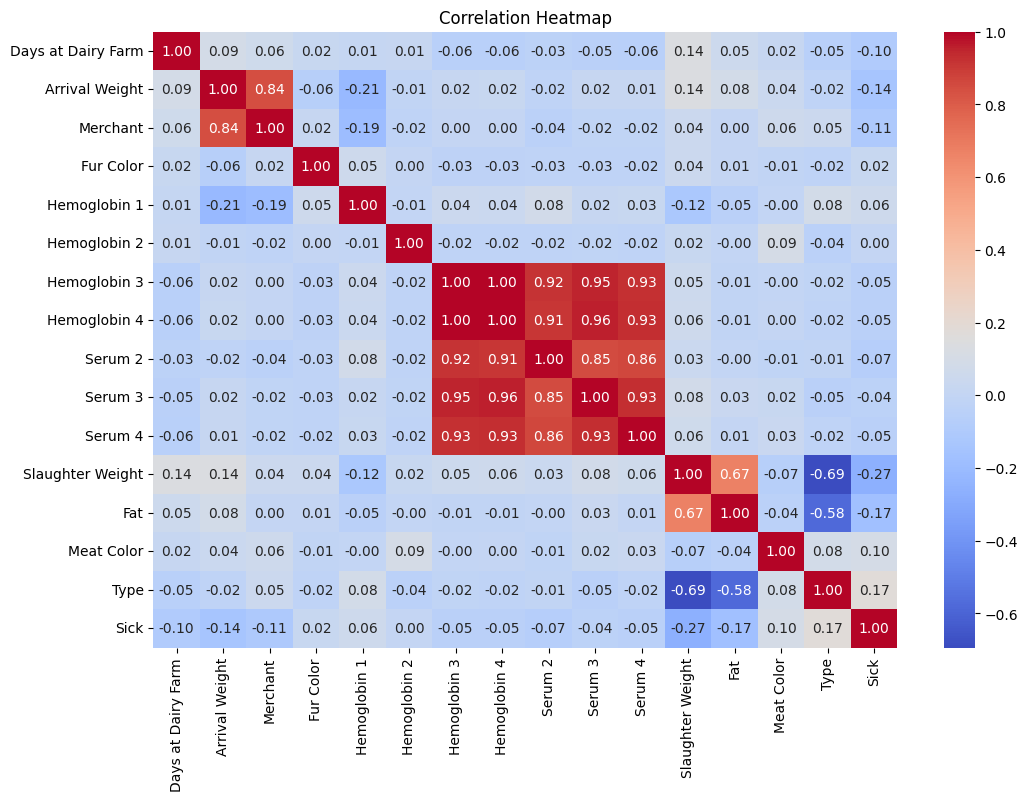

In [290]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

### Group 2308249 Pali

In [291]:
df_blood_2308249, df_slh_2308249P = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2308249 - blood samples',
    name_slh='Group 2308249 SlaughterhouseP',
)

In [292]:
same_cows_2308249P = get_same_cows_ids(df_blood_2308249, df_slh_2308249P) 

In [293]:
len(same_cows_2308249P)

626

In [294]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249P, same_cows_2308249P)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


In [295]:
df_stallijst_2308249 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


In [296]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


In [297]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [298]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking',
       'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum',
       'Slacht datum', 'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [299]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves (1s in Sick column): {count_sick}')

Count of sick calves (1s in Sick column): 123


In [300]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [301]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Volgnr.', 'Koppel',
       'Type', 'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [302]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Type', 'Vetbedekking',
       'Kleur', 'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Arrival weight', 'Sickness Date',
       'Sick'],
      dtype='object')


In [303]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               12             1.916933
HB3                              597            95.367412
HB4                              598            95.527157
S2                                12             1.916933
S3                               597            95.367412
S4                               598            95.527157
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      517            82.587859
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID     

In [304]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3  HB4   S2   S3   S4 Type  Vetbedekking  Kleur  Gewicht  \
0  6.3  6.0  0.0  0.0  0.0  0.0  0.0   O0            20      4    123.0   
1  5.9  4.7  0.0  0.0  0.0  0.0  0.0   O0            20      4    120.0   
2  4.3  5.2  0.0  0.0  0.0  0.0  0.0   O0            20      4    128.5   
3  6.0  5.5  0.0  0.0  0.0  0.0  0.0   O-            20      5    107.9   
4  5.9  6.3  0.0  0.0  0.0  0.0  0.0   O0            30      5    142.4   

  Geboorte datum Slacht datum  Afwijkingen       Calf ID Calf ID + Country  \
0       5-2-2023    24-8-2023            0  217760131203   IE 217760131203   
1       8-2-2023    24-8-2023            1  222187992727   IE 222187992727   
2       7-2-2023    24-8-2023            0  224114582723   IE 224114582723   
3       1-2-2023    24-8-2023            0  215791893047   IE 215791893047   
4       4-2-2023    24-8-2023            0  224974482092   IE 224974482092   

  County ID                 Merchant  Sex Color Letter  Fur Color  \
0        IE

In [305]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Type', 'Fat Covering', 'Meat Color',
       'Slaughter Weight', 'Birth Date', 'Slaughter Date', 'Abnormalities',
       'Calf ID', 'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Stable', 'Arrival Weight', 'Sickness Date',
       'Sick'],
      dtype='object')


In [306]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3',
    'Hemoglobin 4', 
    'Serum 2', 
    'Serum 3',
    'Serum 4',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2308249_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_pali.columns)

print(df_final_cleaned_2308249_pali.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Sickness Date', 'Sick',
       'Slaughter Date', 'Slaughter Weight', 'Fat Covering', 'Meat Color',
       'Type', 'Abnormalities'],
      dtype='object')
    Country ID + Calf ID Country ID       Calf ID Birth Date  Sex    Stable  \
321      IE 212959131064         IE  212959131064   9-2-2023    1  Vd Borne   
542      IE 223791092733         IE  223791092733   5-2-2023    1  Vd Borne   
439      IE 214610435508         IE  214610435508  31-1-2023    1  Vd Borne   
208      IE 223027526566         IE  223027526566   1-2-2023    1  Vd Borne   
153      IE 217693732825         IE  217693732825   1-2-2023    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Far

In [307]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     1         0    1
4          0     0         0    1


Number of 1's (female): 626
Number of 0's (male): 0


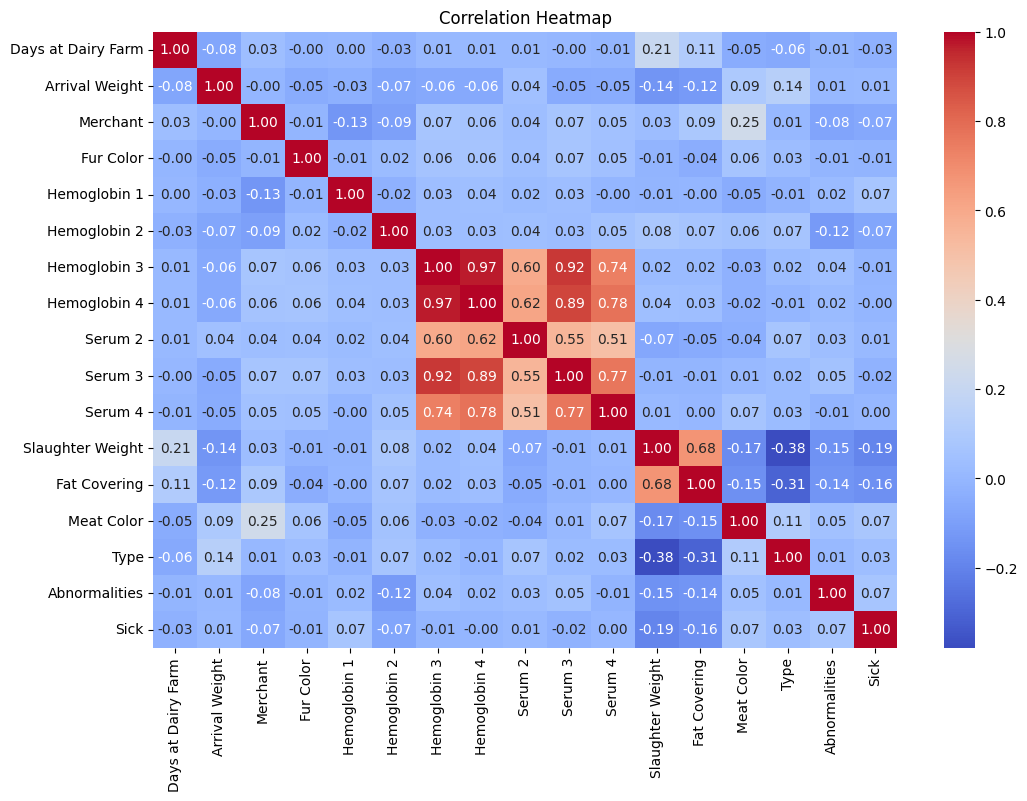

In [308]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Group 2229248

### Group 2229248 S

In [184]:
df_blood_2229248, df_slh_2229248 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2229248 - blood samples',
    name_slh='Group 2229248 Slaughterhouse',
)

In [185]:
same_cows_2229248 = get_same_cows_ids(df_blood_2229248, df_slh_2229248) 

In [186]:
len(same_cows_2229248)

303

In [187]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248, same_cows_2229248)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


In [188]:
df_stallijst_2229248 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm'],
      dtype='object')


In [189]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


In [190]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [191]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [192]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves (1s in Sick column): {count_sick}')

Count of sick calves (1s in Sick column): 93


In [193]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [194]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [195]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Slacht Datum', 'Calf ID', 'Calf ID + Country',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [196]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                2             0.660066
HB3                              280            92.409241
S2                                 2             0.660066
S3                               280            92.409241
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

In [197]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3   S2   S3  Gewicht  Soort  Kleur  Vet        Geboortedatum  \
0  5.4  6.8  0.0  0.0  0.0    129.6     12      5    2            7/13/2022   
1  7.1  7.2  0.0  0.0  0.0    133.5     12      5    2            7/16/2022   
2  6.3  5.9  0.0  0.0  0.0    147.2     11      4    3            7/17/2022   
3  6.5  6.1  0.0  0.0  0.0    173.5     11      4    3            7/16/2022   
4  6.5  6.1  0.0  0.0  0.0    162.3     12      4    3  2022-08-07 00:00:00   

  Slacht Datum     Calf ID Calf ID + Country County ID  Merchant  Sex  \
0   2023-06-02  1406655252     DE 1406655252        DE  lochimex    1   
1   2023-06-02  1406681809     DE 1406681809        DE  lochimex    1   
2   2023-06-02  1406572274     DE 1406572274        DE  lochimex    1   
3   2023-06-02  1406701934     DE 1406701934        DE  lochimex    1   
4   2023-06-02  1406572597     DE 1406572597        DE  lochimex    1   

  Color Letter         Fur Color Arrival Date at Veal Farm  \
0            Z         Z

In [198]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Slaughter Date', 'Calf ID', 'Country ID + Calf ID', 'Country ID',
       'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [199]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2229248_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_s.columns)

print(df_final_cleaned_2229248_s.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')
    Country ID + Calf ID Country ID     Calf ID           Birth Date  Sex  \
275        DE 1604511628         DE  1604511628  2022-08-07 00:00:00    1   
229        DE 1272818074         DE  1272818074  2022-06-07 00:00:00    1   
266        DE 1269773961         DE  1269773961  2022-12-07 00:00:00    0   
195        DE 1406562906         DE  1406562906  2022-07-07 00:00:00    1   
108        DE 1406768537         DE  1406768537  2022-12-07 00:00:00    1   

       Stable  Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
275  Vd Borne                  19        

In [200]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          1         0    1
3          0         0    1
4          0         0    1


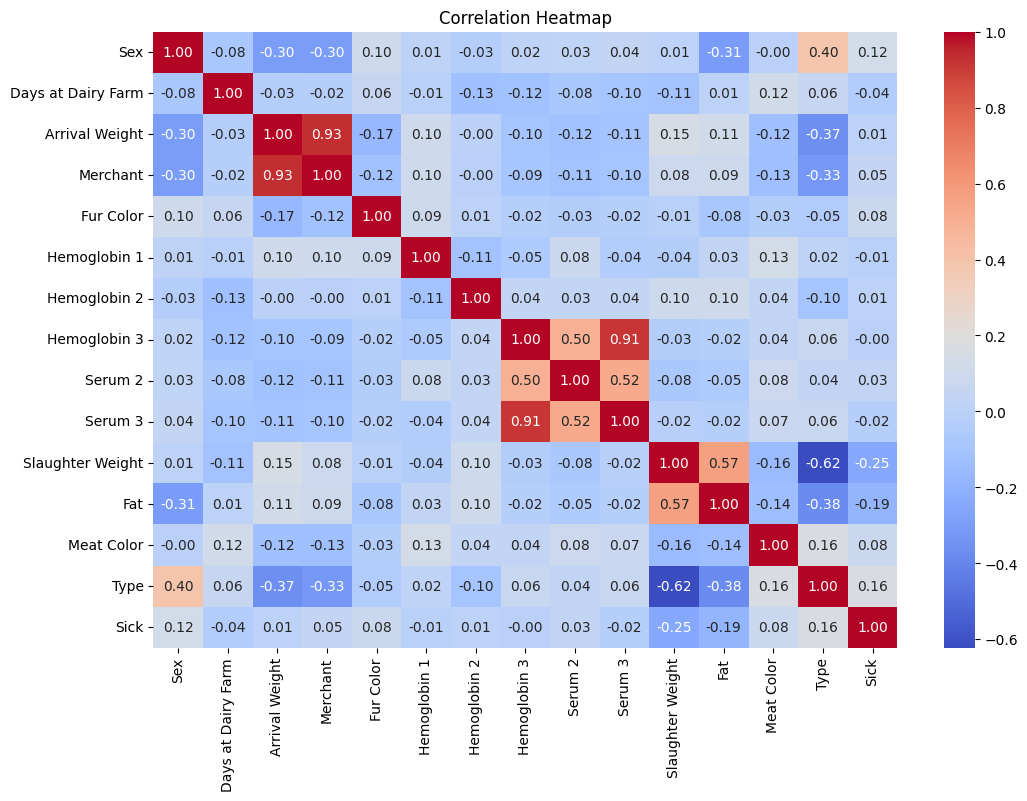

In [201]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

### Group 2229248 Pali

In [202]:
df_blood_2229248, df_slh_2229248P = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2229248 - blood samples',
    name_slh='Group 2229248 SlaughterhouseP',
)

In [203]:
same_cows_2229248P = get_same_cows_ids(df_blood_2229248, df_slh_2229248P) 

In [204]:
len(same_cows_2229248P)

120

In [205]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248P, same_cows_2229248P)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


In [206]:
df_stallijst_2229248 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


In [207]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


In [208]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [209]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [210]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [211]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [212]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [213]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.840336
HB3                              116            97.478992
S2                                 1             0.840336
S3                               116            97.478992
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                       84            70.588235
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

In [214]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3   S2   S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  6.0  5.2  0.0  0.0  0.0   O-            20      5    124.3      14-7-2022   
1  7.3  5.7  0.0  0.0  0.0   O-            30      6    128.5      17-7-2022   
2  6.2  5.3  0.0  0.0  0.0   P0            20      5    122.8       5-7-2022   
3  5.7  6.4  0.0  0.0  0.0   O+            30      6    160.6      17-7-2022   
4  5.4  5.3  0.0  0.0  0.0   O-            20      5    124.2      14-7-2022   

  Slacht datum  Afwijkingen     Calf ID Calf ID + Country County ID  \
0     6-2-2023            0  1406570666     DE 1406570666        DE   
1     6-2-2023            1  1406686947     DE 1406686947        DE   
2     6-2-2023            1  1406570654     DE 1406570654        DE   
3     6-2-2023            0  1604557390     DE 1604557390        DE   
4     6-2-2023            0  1406570665     DE 1406570665        DE   

     Merchant  Sex Color Letter  Fur Color Arrival Date at Veal Farm  \
0  Pali BV BA    0  

In [215]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [216]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2229248_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_pali.columns)

print(df_final_cleaned_2229248_pali.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')
   Country ID + Calf ID Country ID     Calf ID Birth Date  Sex    Stable  \
70        DE 1406789499         DE  1406789499  18-7-2022    1  Vd Borne   
39        DE 1406651310         DE  1406651310  13-7-2022    1  Vd Borne   
14        DE 1406686943         DE  1406686943  13-7-2022    1  Vd Borne   
83        DE 1406598745         DE  1406598745  15-7-2022    1  Vd Borne   
3         DE 1604557390         DE  1604557390  17-7-2022    1  Vd Borne   

    Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight    Merchant  \
70                  

In [217]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    0
1          0     0         0    0
2          0     1         0    0
3          0     2         0    1
4          0     0         0    0


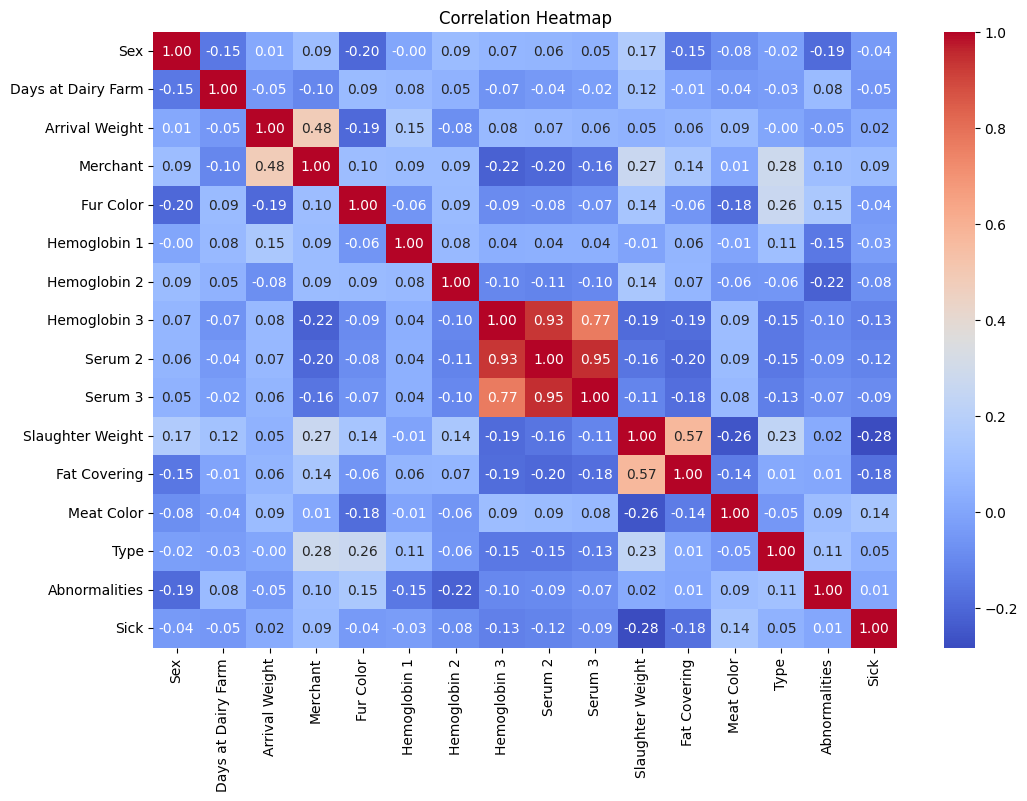

In [218]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Group 2151247

### Group 2151247 S

In [118]:
df_blood_2151247, df_slh_2151247 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2151247 - blood samples',
    name_slh='Group 2151247 Slaughterhouse',
)
same_cows_2151247 = get_same_cows_ids(df_blood_2151247, df_slh_2151247) 
len(same_cows_2151247)

518

In [119]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247, same_cows_2151247)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst'],
      dtype='object')


In [120]:
df_stallijst_2151247 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


In [121]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


In [122]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [123]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [124]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves (1s in Sick column): {count_sick}')

Count of sick calves (1s in Sick column): 184


In [125]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [126]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X',
       'County ID', 'Birth Date', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Calf ID + Country', 'Stable', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [127]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'X', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Calf ID', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Sickness Date', 'Sick'],
      dtype='object')


In [128]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               11             2.123552
HB3                              495            95.559846
S2                                11             2.123552
S3                               495            95.559846
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter                       0             0.000000
Fur Color                          0             0.000000
Arrival Date a

In [129]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3   S2   S3  Gewicht  Soort  Kleur  Vet        Geboortedatum  \
0  6.3  5.1  0.0  0.0  0.0    123.2     12      5    2  2021-06-12 00:00:00   
1  6.3  5.7  0.0  0.0  0.0    118.6     13      5    2  2021-10-12 00:00:00   
2  5.5  5.9  0.0  0.0  0.0    155.2     12      6    2  2021-07-12 00:00:00   
3  6.3  6.1  0.0  0.0  0.0    146.8     13      6    2  2021-09-12 00:00:00   
4  5.5  7.8  0.0  0.0  0.0    142.5     12     10    2  2021-09-12 00:00:00   

     Calf ID County ID     Merchant  Sex Color Letter  Fur Color  \
0  892646108        NL  sloot, bert    0           ZB  Zwartbont   
1  578626691        NL  sloot, bert    1           ZB  Zwartbont   
2  609609778        NL  sloot, bert    1           ZB  Zwartbont   
3  567928315        NL  sloot, bert    1           ZB  Zwartbont   
4  573265196        NL  sloot, bert    1           ZB  Zwartbont   

  Arrival Date at Veal Farm  Days at diary farm Calf ID + Country    Stable  \
0                2021-12-23          

In [130]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Country ID + Calf ID', 'Stable', 'Arrival Weight', 'Sickness Date',
       'Sick'],
      dtype='object')


In [131]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2151247_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_s.columns)

print(df_final_cleaned_2151247_s.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Weight', 'Fat', 'Meat Color',
       'Type'],
      dtype='object')
    Country ID + Calf ID Country ID     Calf ID           Birth Date  Sex  \
197         NL 572288820         NL   572288820  2021-09-12 00:00:00    1   
386        DE 1306642315         DE  1306642315  2021-02-12 00:00:00    1   
270         LU 818154435         LU   818154435           11/30/2021    1   
308        DE 1306639053         DE  1306639053           11/24/2021    0   
68          NL 609305016         NL   609305016  2021-06-12 00:00:00    1   

       Stable  Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
197  Vd Borne                  14                2021-12-23

In [132]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0    12         0    0
1          0    13         0    1
2          0    12         0    1
3          0    13         0    1
4          0    12         0    1


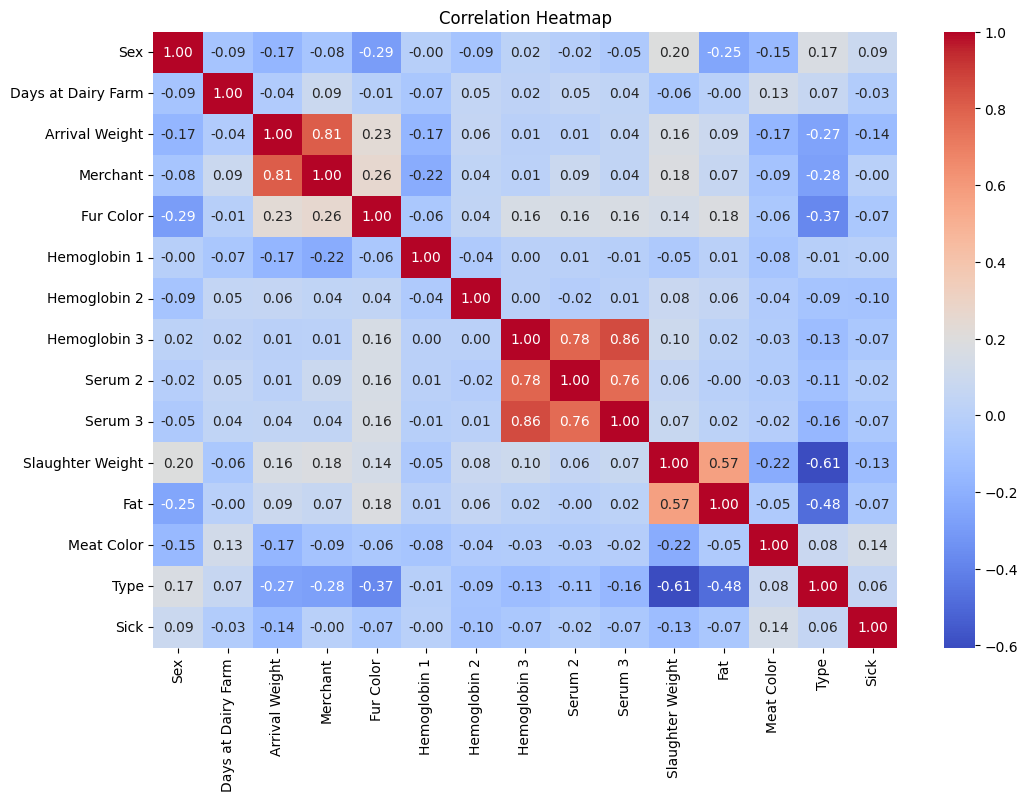

In [133]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

### Group 2151247 Pali

In [134]:
df_blood_2151247, df_slh_2151247P = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2151247 - blood samples',
    name_slh='Group 2151247 SlaughterhouseP',
)
same_cows_2151247P = get_same_cows_ids(df_blood_2151247, df_slh_2151247P) 
len(same_cows_2151247P)

145

In [135]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247P, same_cows_2151247P)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


In [136]:
df_stallijst_2151247 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


In [137]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


In [138]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [139]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


In [140]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


In [141]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


In [142]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'X', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [143]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.689655
HB3                              141            97.241379
S2                                 1             0.689655
S3                               141            97.241379
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      109            75.172414
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

In [144]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

print(df_final_cleaned.head())

   HB1  HB2  HB3   S2   S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  5.3  6.5  0.0  0.0  0.0   O-            20      5    157.1     29-11-2021   
1  5.5  6.3  0.0  0.0  0.0   O-            20      5    140.1     27-11-2021   
2  6.0  5.8  0.0  0.0  0.0   O-            20      6    146.7     27-11-2021   
3  6.0  5.1  0.0  0.0  0.0   O-            20      6    142.5     28-11-2021   
4  5.7  5.6  0.0  0.0  0.0   O-            20      5    144.9      1-12-2021   

  Slacht datum  Afwijkingen     Calf ID County ID     Merchant  Sex  \
0     1-7-2022            0  1406595212        DE     lochimex    1   
1     1-7-2022            0  1604424000        DE     lochimex    1   
2     1-7-2022            0  1406533395        DE     lochimex    1   
3     1-7-2022            0  1406534595        DE     lochimex    1   
4     1-7-2022            0   681201068        NL  sloot, bert    1   

  Color Letter  Fur Color Arrival Date at Veal Farm  Days at diary farm  \
0           ZB  Z

In [145]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


In [146]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2151247_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_pali.columns)

print(df_final_cleaned_2151247_pali.sample(5))

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')
    Country ID + Calf ID Country ID     Calf ID  Birth Date  Sex    Stable  \
133        DE 1604458435         DE  1604458435   4-12-2021    1  Vd Borne   
65         DE 1406576923         DE  1406576923   5-12-2021    1  Vd Borne   
1          DE 1604424000         DE  1604424000  27-11-2021    1  Vd Borne   
62         DE 1406547986         DE  1406547986   5-12-2021    1  Vd Borne   
86         DE 1406501876         DE  1406501876   2-12-2021    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  Merchant  \
133      

In [147]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     0         0    1
4          1     0         1    1


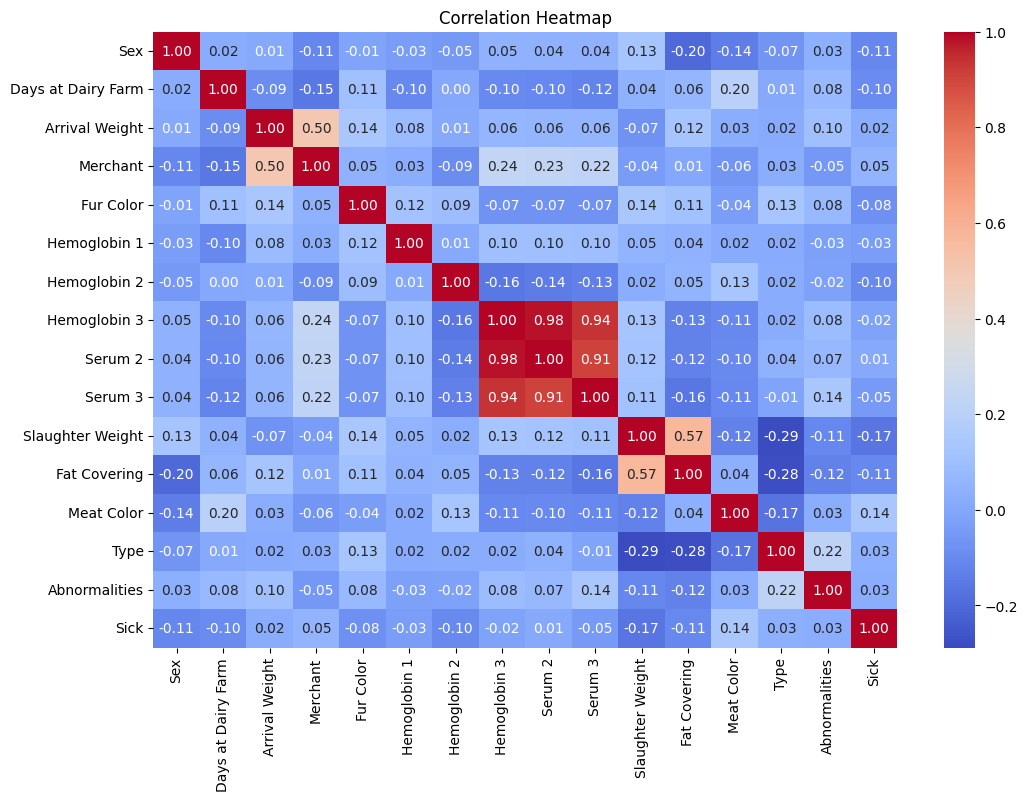

In [148]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Combined Data

### Data SlaughterhouseS

In [149]:
combined_df = pd.concat([
    df_final_cleaned_2308249_s,
    df_final_cleaned_2229248_s, 
    df_final_cleaned_2151247_s
], ignore_index=True)

print(len(combined_df))

count_sick = combined_df['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

1367
Count of sick calves: 435


In [150]:
nan_counts = combined_df.isna().sum()
total_counts = len(combined_df)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

In [151]:
combined_df['Fur Color'] = pd.factorize(combined_df['Fur Color'])[0]
combined_df['Merchant'] = pd.factorize(combined_df['Merchant'])[0]
combined_df['Country ID'] = pd.factorize(combined_df['Country ID'])[0]

unique_counts = {
    'Fur Color': combined_df['Fur Color'].nunique(),
    'Merchant': combined_df['Merchant'].nunique(),
    'Country ID': combined_df['Country ID'].nunique()
}

print(unique_counts)

print(combined_df[['Fur Color', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 6, 'Merchant': 7, 'Country ID': 4}
   Fur Color  Merchant  Country ID
0          0         0           0
1          0         0           0
2          0         0           0
3          0         0           0
4          0         0           0


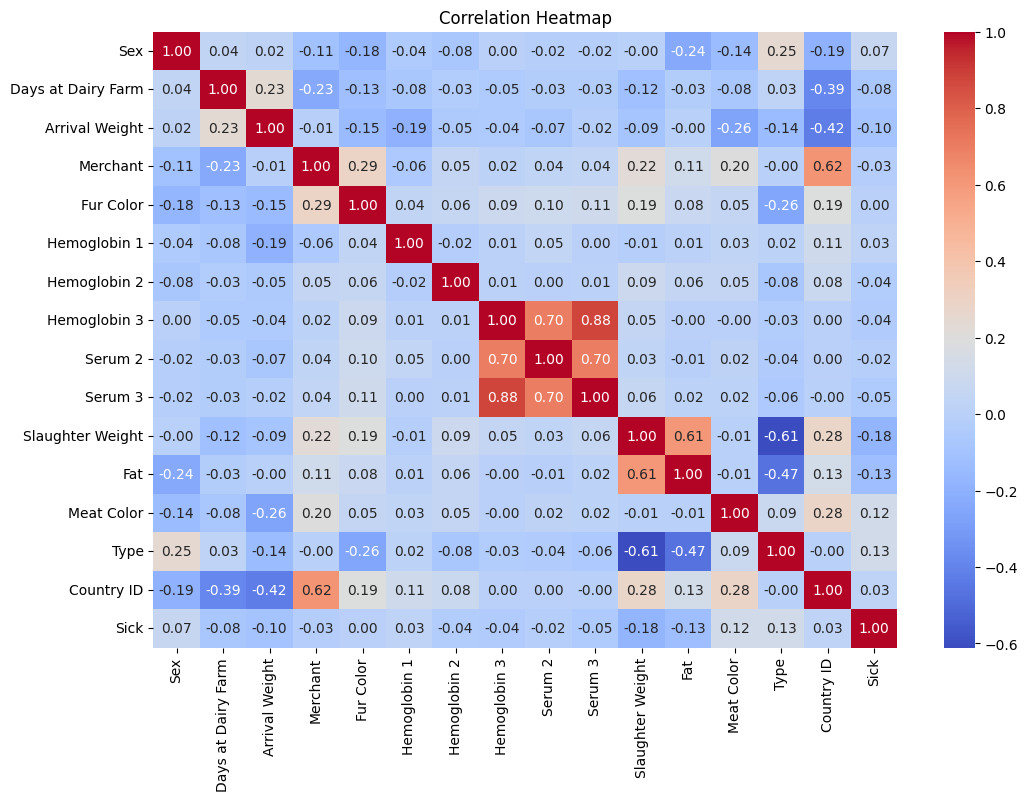

In [152]:
numeric_df = combined_df[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat', 'Meat Color', 'Type', 'Country ID', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

### Data SlaughterhouseP

In [153]:
combined_df = pd.concat([
    df_final_cleaned_2412242_pali, 
    df_final_cleaned_2336241_pali,
    df_final_cleaned_2308249_pali, 
    df_final_cleaned_2229248_pali, 
    df_final_cleaned_2151247_pali
], ignore_index=True)

print(len(combined_df))

count_sick = combined_df['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

2243
Count of sick calves: 381


In [154]:
nan_counts = combined_df.isna().sum()
total_counts = len(combined_df)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

In [155]:
combined_df['Fur Color'] = pd.factorize(combined_df['Fur Color'])[0]
combined_df['Type'] = pd.factorize(combined_df['Type'])[0]
combined_df['Merchant'] = pd.factorize(combined_df['Merchant'])[0]
combined_df['Country ID'] = pd.factorize(combined_df['Country ID'])[0]

unique_counts = {
    'Fur Color': combined_df['Fur Color'].nunique(),
    'Type': combined_df['Type'].nunique(),
    'Merchant': combined_df['Merchant'].nunique(),
    'Country ID': combined_df['Country ID'].nunique()
}

print(unique_counts)

print(combined_df[['Fur Color', 'Type', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 6, 'Type': 9, 'Merchant': 9, 'Country ID': 5}
   Fur Color  Type  Merchant  Country ID
0          0     0         0           0
1          1     1         0           0
2          0     0         0           0
3          1     1         0           0
4          1     2         0           0


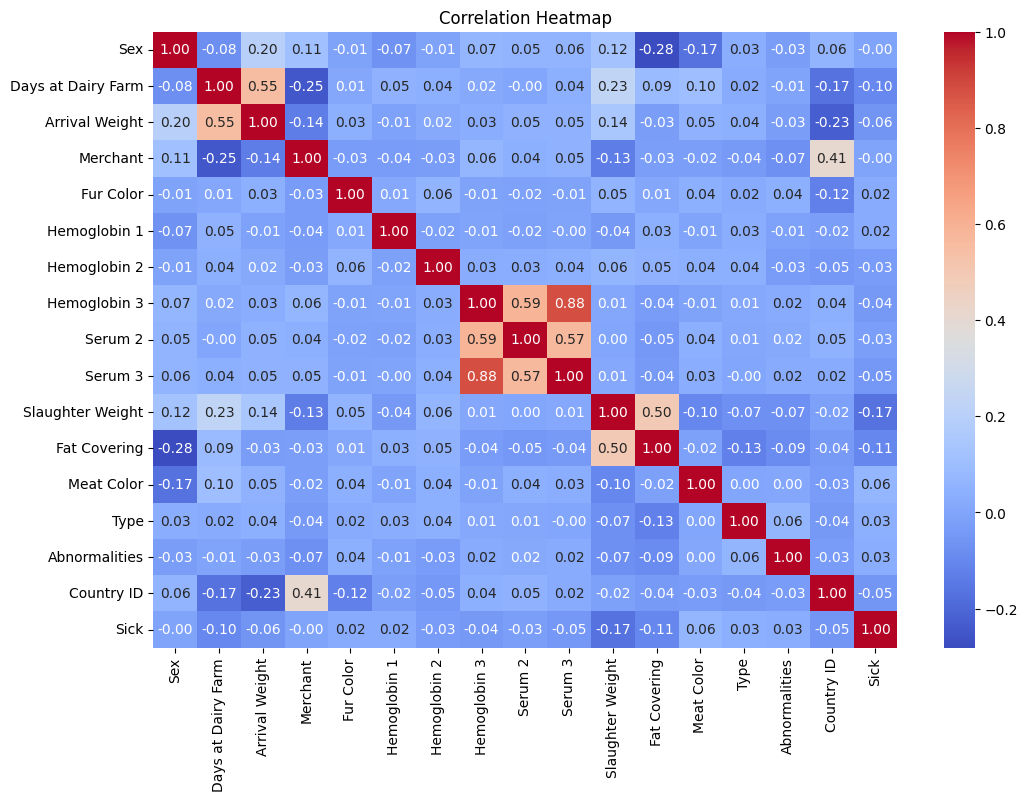

In [156]:
numeric_df = combined_df[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat Covering', 'Meat Color', 'Type', 
                          'Abnormalities', 'Country ID', 'Sick']]

correlations = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Support Vector Machine (Regression)

In [157]:
scaler = StandardScaler()

df_scaled_numeric = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

features = df_scaled_numeric.drop(columns='Sick').columns
target = "Sick"

X = df_scaled_numeric[features]
y = df_scaled_numeric[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

model = SVR()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
Model R^2: -0.03
Root Mean Squared Error (RMSE): 0.92
Mean Absolute Error (MAE): 0.42
Cross-Validation R^2 scores: [-0.01824039 -0.14158715 -0.03991073 -0.11625384 -0.24787183]
Mean Cross-Validation R^2: -0.11


## Individual treatments

In [158]:
borne_treatments = pd.read_excel("C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", sheet_name='Individual treatments')

In [159]:
borne_treatments.head(3)

,Volgnummer,Datum,Lev.nr,Werknr,Hoknr,Diagnose,Medicijn,Registratienr,Per dier,Dosering Per dier,Naam,Interval,Wachttijd,Wachttijd 2,Dgn,Opmerking
0,2024-04-03,11/24/2221,DK 03442604712,4712,NaN,Longontsteking pompers,Genta-ject 10% inj.,REG NL 1637,7,ml,NaN,24,2222-12-04 00:00:00,NaN,NaN,NaN
1,2024-03-03,8/14/2024,IE 224075911726,11726,NaN,Longontsteking pompers,DEPOCILLINE,REG NL 4259,18,ml,NaN,24,8/21/2024,NaN,NaN,NaN
2,2024-01-01,8/14/2024,IE 215273412531,12531,NaN,kalf staat vol,Buscopan comp. inj.,REG NL 8944,9,ml,NaN,0,8/29/2024,NaN,NaN,NaN


In [160]:
cows_in_all_borne = ( same_cows_2412242 | same_cows_2336241 | same_cows_2308249 | same_cows_2308249P | same_cows_2229248 | same_cows_2229248P | same_cows_2151247 | same_cows_2151247P).intersection(set(borne_treatments['Lev.nr']))

In [161]:
len(cows_in_all_borne)

816

## Get sick cows sample

In [162]:
sick_cows_df = borne_treatments[borne_treatments['Lev.nr'].isin(cows_in_all_borne)]
sick_cows_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, 1 to 4978
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Volgnummer         2273 non-null   datetime64[ns]
 1   Datum              2273 non-null   object        
 2   Lev.nr             2273 non-null   object        
 3   Werknr             2273 non-null   int64         
 4   Hoknr              0 non-null      float64       
 5   Diagnose           2273 non-null   object        
 6   Medicijn           2273 non-null   object        
 7   Registratienr      2273 non-null   object        
 8   Per dier           2273 non-null   int64         
 9   Dosering Per dier  2273 non-null   object        
 10  Naam               0 non-null      float64       
 11  Interval           2273 non-null   int64         
 12  Wachttijd          2273 non-null   object        
 13  Wachttijd 2        0 non-null      float64       
 14  Dgn          

In [163]:
sick_cows_df['Datum'] = pd.to_datetime(sick_cows_df['Datum'])

C:\Users\wimva\AppData\Local\Temp\ipykernel_26380\3366543722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sick_cows_df['Datum'] = pd.to_datetime(sick_cows_df['Datum'])


In [164]:
sick_cows_df = sick_cows_df.sort_values(by='Datum')
# for now, only keep one record for each sick cow
sick_cows_df = sick_cows_df.drop_duplicates(subset=['Lev.nr'], keep='last')

In [165]:
sick_cows_df

,Volgnummer,Datum,Lev.nr,Werknr,Hoknr,Diagnose,Medicijn,Registratienr,Per dier,Dosering Per dier,Naam,Interval,Wachttijd,Wachttijd 2,Dgn,Opmerking
4950,2024-03-03,2021-12-18,DE 1406617767,17767,NaN,Navelontsteking,DEPOCILLINE,REG NL 4259,4,ml,NaN,24,#########,NaN,NaN,NaN
4943,2024-03-03,2021-12-19,DE 1406576892,76892,NaN,Longontsteking pompers,DEPOCILLINE,REG NL 4259,4,ml,NaN,24,#########,NaN,NaN,NaN
4931,2024-04-04,2021-12-20,DE 1604501679,1679,NaN,Longontsteking pompers,Genta-ject 10% inj.,REG NL 1637,4,ml,NaN,24,2022-08-05 00:00:00,NaN,NaN,NaN
4885,2024-04-04,2021-12-23,NL 572288820,8882,NaN,Longontsteking pompers,Genta-ject 10% inj.,REG NL 1637,4,ml,NaN,24,2022-11-05 00:00:00,NaN,NaN,NaN
4868,2024-04-04,2021-12-24,DE 1406527581,27581,NaN,Longontsteking pompers,Genta-ject 10% inj.,REG NL 1637,5,ml,NaN,24,2022-12-05 00:00:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2024-01-01,2024-12-04,IE 219620261489,61489,NaN,Longontsteking pompers,Resflor,REG NL 10539,6,ml,NaN,0,5/28/2024,NaN,NaN,NaN
327,2024-01-01,2024-12-04,IE 224811231690,31690,NaN,Longontsteking pompers,Resflor,REG NL 10539,6,ml,NaN,0,5/28/2024,NaN,NaN,NaN
320,2024-03-01,2024-12-04,IE 212101761681,61681,NaN,Gewrichtsontsteking,Albipen LA,REG NL 7828,10,ml,NaN,48,2024-10-05 00:00:00,NaN,NaN,NaN
50,2024-01-01,2024-12-06,IE 227410710387,10387,NaN,Longontsteking pompers,Resflor,REG NL 10539,13,ml,NaN,0,7/28/2024,NaN,NaN,NaN


# Get non-sick cows sample

In [35]:
non_sick_cows_ids = ( same_cows_2412242 | same_cows_2336241 | same_cows_2308249 | same_cows_2308249P | same_cows_2229248 | same_cows_2229248P | same_cows_2151247 | same_cows_2151247P) - set(sick_cows_df['Lev.nr'])

In [36]:
len(non_sick_cows_ids)

2795

## Merge datasets

In [37]:
df_blood_2308249.dropna(axis=1, how='all').rename(
    {'cow_id': 'ID nummer'}, axis=1
).set_index('ID nummer').join(
    df_slh_2308249.dropna(axis=1, how='all').set_index('ID nummer'), how='inner'
)

,Land,Levensnr,HB1,HB2,HB3,HB4,S2,S3,S4,WerkNr,#,Gewicht,Soort,Kleur,Vet,Geboortedatum,Leeftijdscode,Sekse,Slacht Datum
ID nummer,,,,,,,,,,,,,,,,,,,
IE 222680862571,IE,222680862571,6.4,6.2,NaN,NaN,0.0,NaN,NaN,62571,1308,112.0,13,6,2,2023-01-02 00:00:00,V,STIER,8/23/2023
IE 214158682440,IE,214158682440,5.7,5.1,NaN,NaN,0.0,NaN,NaN,82440,1184,128.9,11,6,2,2023-07-02 00:00:00,V,STIER,8/23/2023
IE 223849832428,IE,223849832428,6.7,5.6,NaN,NaN,0.0,NaN,NaN,32428,1226,108.2,12,7,2,2023-07-02 00:00:00,V,STIER,8/22/2023
IE 217152272253,IE,217152272253,5.2,5.2,NaN,NaN,0.0,NaN,NaN,72253,1209,129.0,11,1,2,2023-07-02 00:00:00,V,STIER,8/22/2023
IE 219154364201,IE,219154364201,6.2,6.4,NaN,NaN,0.0,NaN,NaN,64201,1239,90.9,14,6,1,2023-05-02 00:00:00,V,STIER,8/23/2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IE 224540571812,IE,224540571812,5.3,5.3,NaN,NaN,0.0,NaN,NaN,71812,892,158.6,11,6,3,1/28/2023,V,STIER,8/22/2023
IE 219404731629,IE,219404731629,6.4,6.1,NaN,NaN,0.0,NaN,NaN,31629,1314,175.7,9,3,2,1/26/2023,V,STIER,8/22/2023
IE 213733463464,IE,213733463464,5.2,6.8,NaN,NaN,0.0,NaN,NaN,63464,881,135.8,11,5,2,1/17/2023,V,STIER,8/22/2023
